Calling All Autobots

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure

Function for histogram matching

In [2]:
# Function for histogram matching
def histogram_matching(source, template):
    matched = exposure.match_histograms(source, template, channel_axis=None)
    return matched

Dataset

In [3]:
image1 = 'Images/training/drishtiGS_017.png'
image2 = 'Images/training/drishtiGS_032.png'
image3 = 'Images/training/drishtiGS_036.png'
image4 = 'Images/training/drishtiGS_037.png'
image5 ='Images/training/drishtiGS_040.png'
image6 = 'Images/training/drishtiGS_042.png'
image7 = 'Images/training/drishtiGS_049.png'
image8 = 'Images/training/drishtiGS_057.png'
image9 = 'Images/training/drishtiGS_060.png'
image10 = 'Images/training/drishtiGS_063.png'
image11 = 'Images/training/drishtiGS_064.png'
image12 = 'Images/training/drishtiGS_066.png'
image13 = 'Images/training/drishtiGS_068.png'
image14 = 'Images/training/drishtiGS_069.png'
image15 = 'Images/training/drishtiGS_080.png'
image16 = 'Images/training/drishtiGS_081.png'
image17 = 'Images/training/drishtiGS_084.png'
image18 = 'Images/training/drishtiGS_088.png'
image19 = 'Images/training/drishtiGS_094.png'
image20 = 'Images/training/drishtiGS_098.png'

Read reference image

In [4]:
# Read reference image and input image
reference_image_path = 'Images/training/drishtiGS_037.png'
# Load the images
reference_image = cv2.imread(reference_image_path)
# Convert images to grayscale
gray_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)


Load Images

In [5]:
fundus_image_path = 'Images/training/drishtiGS_094.png'
fundus_image = cv2.imread(fundus_image_path)

gray_image = cv2.cvtColor(fundus_image, cv2.COLOR_BGR2GRAY)

Histogram Matching

In [6]:
# Perform histogram matching
matched_image = histogram_matching(gray_image, gray_reference)

1st Cropping

In [7]:
# Get the dimensions of the image
height, width, _ = fundus_image.shape

# Crop the image along the y-axis from 700 to 1400
# Taking the entire width for x-axis
fundus_cropped = matched_image[550:1300, 0:width]
RGB_cropped = fundus_image[550:1300, 0:width]

Thresholding

In [8]:
# Apply thresholding
_, binary_image = cv2.threshold(fundus_cropped, 100, 255, cv2.THRESH_BINARY)

Opening Closing

In [9]:
# Perform morphological closing
kernel_open = np.ones((20, 20), np.uint8)
opened_image=cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_open)
kernel_close = np.ones((100,100),np.uint8)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel_close)

Convert closed_image to grayscale

In [10]:
# Convert closed_image to grayscale if it's not already in grayscale
if len(closed_image.shape) > 2:
    closed_image_gray = cv2.cvtColor(closed_image, cv2.COLOR_BGR2GRAY)
else:
    closed_image_gray = closed_image

# Ensure the image is in the correct format (CV_8UC1)
closed_image_uint8 = np.uint8(closed_image_gray)

Contours

In [11]:
# Find contours
contours, _ = cv2.findContours(closed_image_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if not contours:
    raise ValueError("No contours found in the image")

# Get the largest contour
largest_contour = max(contours, key=cv2.contourArea)

2nd Cropping

In [12]:
# Get the bounding rectangle of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Ensure the crop area is within the image bounds
y1, y2 = max(0, y-30), min(fundus_cropped.shape[0], y+h+30)
x1, x2 = max(0, x-30), min(fundus_cropped.shape[1], x+w+30)

# Crop the image to the bounding rectangle
optic_disc_cropped = fundus_cropped[y1:y2, x1:x2]
optic_disc_RGB = RGB_cropped[y1:y2, x1:x2]

Draw Contours

In [13]:
# Draw the contours on the original image
contour_image = fundus_cropped.copy()
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)

array([[2.29531272, 2.9739821 , 2.29531272, ..., 2.29531272, 2.29531272,
        1.22529764],
       [2.29531272, 2.9739821 , 2.29531272, ..., 2.29531272, 2.29531272,
        2.29531272],
       [2.29531272, 1.22529764, 1.22529764, ..., 2.29531272, 2.29531272,
        2.29531272],
       ...,
       [1.22529764, 1.22529764, 2.29531272, ..., 2.29531272, 2.29531272,
        2.29531272],
       [1.22529764, 1.22529764, 2.29531272, ..., 1.22529764, 1.22529764,
        1.22529764],
       [1.22529764, 1.22529764, 2.29531272, ..., 1.22529764, 1.22529764,
        1.22529764]])

Ellips Fitting for ROI

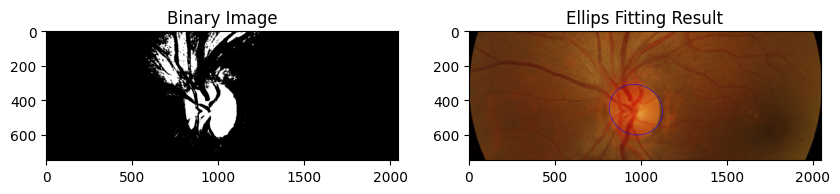

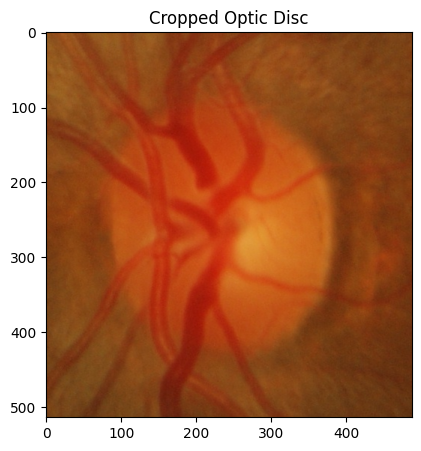

In [14]:
# Find contours
contours, _ = cv2.findContours(closed_image_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if not contours:
    raise ValueError("No contours found in the image")

# Get the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Fit ellipse ke kontur terbesar
if len(largest_contour) >= 5:  # Minimum number of points required to fit ellipse
    ellipse = cv2.fitEllipse(largest_contour)
        
    # Get the parameters of the ellipse
    (center, axes, angle) = ellipse
    center_x, center_y = center
    width, height = axes

    # Calculate bounding box of the ellipse
    x1 = int(center_x - width // 2)-100
    x2 = int(center_x + width // 2)+100
    y1 = int(center_y - height // 2)-100
    y2 = int(center_y + height // 2)+100

    # Ensure the crop area is within the image bounds
    y1, y2 = max(0, y1), min(fundus_cropped.shape[0], y2)
    x1, x2 = max(0, x1), min(fundus_cropped.shape[1], x2)

    # Crop the image to the bounding box of the ellipse
    optic_disc_cropped = fundus_cropped[y1:y2, x1:x2]
    optic_disc_RGB = RGB_cropped[y1:y2, x1:x2]

    # Convert RGB_cropped to RGB format
    color_image = cv2.cvtColor(RGB_cropped, cv2.COLOR_BGR2RGB)

    # Draw ellipse on the color image
    cv2.ellipse(color_image, ellipse, (0, 0, 255), 2)

    # Display the results
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('Binary Image')
    plt.imshow(binary_image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Ellips Fitting Result')
    plt.imshow(color_image)
    plt.show()

    # Display the cropped optic disc region
    plt.figure(figsize=(5, 5))
    plt.title('Cropped Optic Disc')
    plt.imshow(cv2.cvtColor(optic_disc_RGB, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Kontur tidak cukup poin untuk fitting ellips.")

OD Size

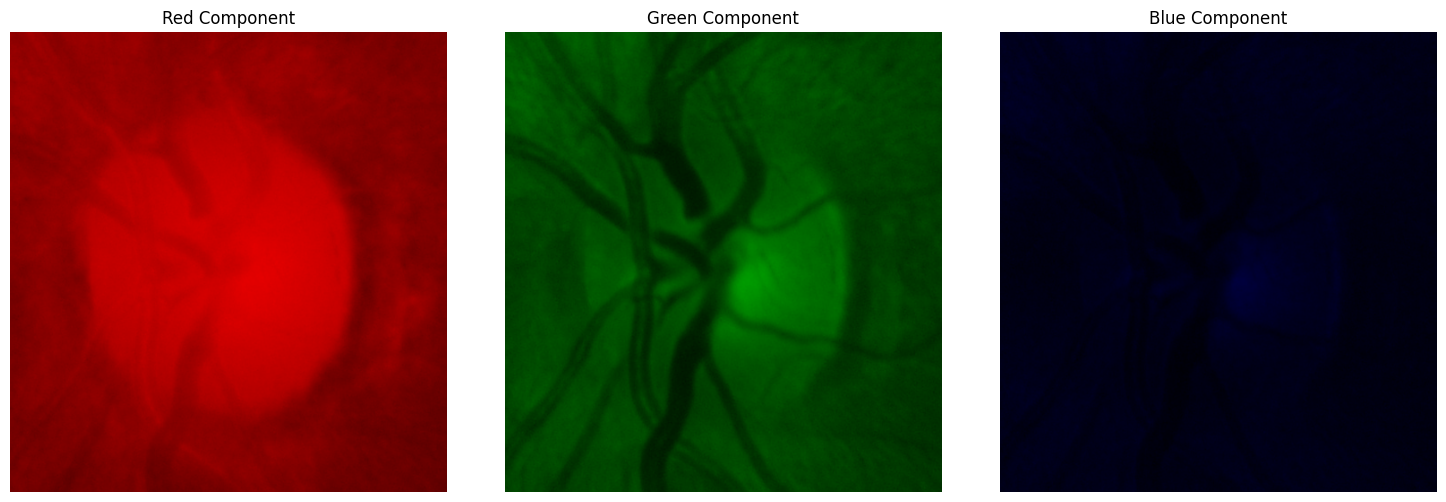

In [18]:
# Pisahkan gambar menjadi tiga komponen warna
B, G, R = cv2.split(optic_disc_RGB)
# Fungsi untuk menampilkan gambar menggunakan matplotlib
def show_image(title, img):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

# Konversi B, G, R dari format OpenCV (BGR) ke format yang bisa ditampilkan matplotlib (RGB)
# Untuk itu, kita perlu mengatur R, G, B ke channel-nya masing-masing di gambar RGB.
zeros = np.zeros_like(B)  # array dengan nilai nol untuk channel lain
R_img = cv2.merge([zeros, zeros, R])  # Hanya komponen merah
G_img = cv2.merge([zeros, G, zeros])  # Hanya komponen hijau
B_img = cv2.merge([B, zeros, zeros])  # Hanya komponen biru

# Menampilkan gambar komponen warna
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
show_image('Red Component', cv2.cvtColor(R_img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
show_image('Green Component', cv2.cvtColor(G_img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
show_image('Blue Component', cv2.cvtColor(B_img, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

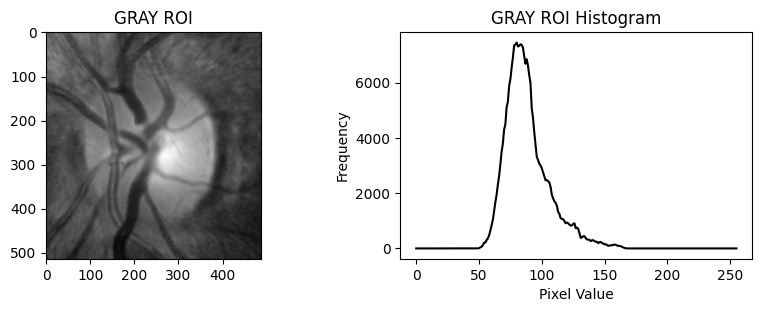

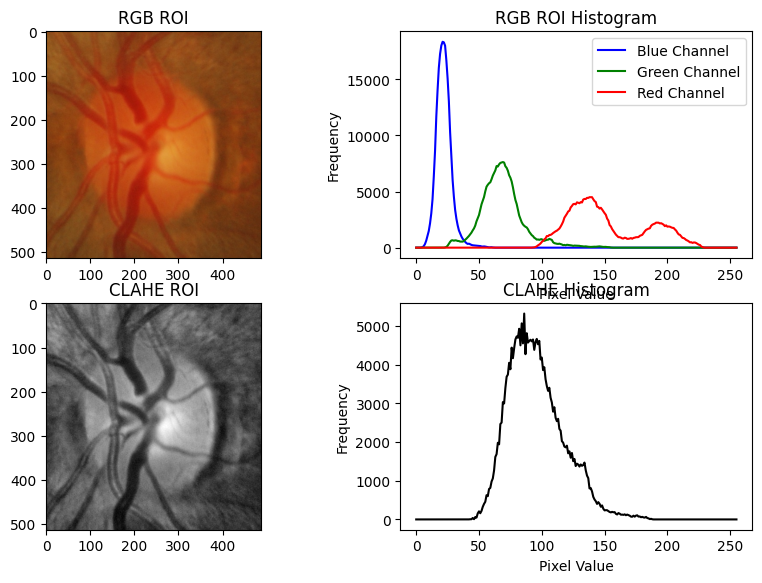

In [16]:
#Pada tahapan menentukan ukuran OD dan OC, akan menggunakan daerah ROI yang disimpan dalam color_image
roi_gray = cv2.cvtColor(optic_disc_RGB, cv2.COLOR_BGR2GRAY)

# Calculate the histogram for normalized grayscale image
hist_roi = cv2.calcHist([roi_gray], [0], None, [256], [0, 256])

# Buat objek CLAHE dengan parameter yang sesuai
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))

# Terapkan CLAHE pada citra grayscale
clahe_output = clahe.apply(roi_gray)

# CLAHE Histogram
hist_clahe = cv2.calcHist([clahe_output], [0], None, [256], [0, 256])

# Calculate the histogram for each channel (B, G, R)
hist_b = cv2.calcHist([optic_disc_RGB], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([optic_disc_RGB], [1], None, [256], [0, 256])
hist_r = cv2.calcHist([optic_disc_RGB], [2], None, [256], [0, 256])

# Display the results
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.title('GRAY ROI')
plt.imshow(roi_gray, cmap='gray')

# Plot normalized grayscale histogram
plt.subplot(3, 2, 2)
plt.plot(hist_roi, color='black')
plt.title('GRAY ROI Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 3)
plt.title('RGB ROI')
plt.imshow(cv2.cvtColor(optic_disc_RGB, cv2.COLOR_BGR2RGB))

# Plot RGB histograms
plt.subplot(3, 2, 4)
plt.plot(hist_b, color='blue', label='Blue Channel')
plt.plot(hist_g, color='green', label='Green Channel')
plt.plot(hist_r, color='red', label='Red Channel')
plt.title('RGB ROI Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 2, 5)
plt.title('CLAHE ROI')
plt.imshow(clahe_output, cmap='gray')

plt.subplot(3, 2, 6)
plt.plot(hist_clahe, color='black')
plt.title('CLAHE Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')